In [35]:
## SETTING UP
# imports
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
import pylab as pl
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import numpy as np
import matplotlib as plt



# Set ipython's max row display
pd.set_option('display.max_row', 100)
# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

# allow plots to appear directly in the notebook
%matplotlib inline


# Data Preperation and Pre-processing

In [4]:
#loans

#Load Loans Data

loan2007 =  pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/LoanStats3a-2007-2011.csv", skiprows=[0])

loan2015 =  pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/LoanStats3d.csv", skiprows=[0])
loan2016Q1 = pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/LoanStats_2016Q1.csv", skiprows=[0])
loan2016Q2 = pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/LoanStats_2016Q2.csv", skiprows=[0])
loan2016Q3 = pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/LoanStats_2016Q3.csv", skiprows=[0])
loan2016Q4 = pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/LoanStats_2016Q4.csv", skiprows=[0])

##rejected Data

rejected2007 =  pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/RejectStatsA-2007-2012.csv", skiprows=[0])

rejected2015 =  pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/RejectStatsD.csv", skiprows=[0])
rejected2016Q1 = pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/RejectStats_2016Q1.csv", skiprows=[0])
rejected2016Q2 = pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/RejectStats_2016Q2.csv", skiprows=[0])
rejected2016Q3 = pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/RejectStats_2016Q3.csv", skiprows=[0])
rejected2016Q4 = pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/RejectStats_2016Q4.csv", skiprows=[0])



/Users/tomereldor/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/tomereldor/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/tomereldor/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/tomereldor/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,19,55,123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set l

KeyboardInterrupt: 

In [ ]:
## Merging each dataset type to a continuous one by years 
## while also dropping the last 2 rows of each dataset, since they are irrelevnat summary stat row
print(loan2015.shape,loan2016Q1.shape, loan2016Q2.shape,loan2016Q3.shape, loan2016Q4.shape)
loans2015_16 = pd.concat([loan2015[:-2], loan2016Q1[:-2], loan2016Q2[:-2], loan2016Q3[:-2], loan2016Q4[:-2]])
rejected2015_16 = pd.concat([rejected2015[:-2], rejected2016Q1[:-2], rejected2016Q2[:-2], rejected2016Q3[:-2], rejected2016Q4[:-2]])

## adding a column for each dataset: accepted or rejected (for later appending the datasets)
loans2015_16['accepted'] = 1
rejected2015_16['accepted'] = 0


In [ ]:
# (recreating rejected dataset if needed)
#rejected2015_16 = pd.concat([rejected2015[:-2], rejected2016Q1[:-2], rejected2016Q2[:-2], rejected2016Q3[:-2], rejected2016Q4[:-2]])
#rejected2015_16['accepted'] = 0

In [ ]:
# data clearning: strip from whitespaces or otherwise mark as null
loans2015_16 = loans2015_16.applymap(lambda x: str(x).strip() if len(str(x).strip()) else None)


### Matching Columns

###### No Risk Column
mutually shared columns are all of the ones of the REJECTED dataset excpet for the Risk_Score column.
RISK measurement doesn't have its parallel data in the loans data (there's no data about vanguard score, which is what we need since this data is newer,and no actually published data 
about the fico score).

###### Unifying Datetime format
Datetime column: the loans dataset contains only month-year, whereas the other contains also day. However, to not have internal differences between the datetypes (and the model assign importance to the difference between 1-of-month to rest-of-month (which in this case the model would take as a strong predictor...), I'm omitting the day factor and keeping only month and year. 

In [ ]:
## rename the rejection columns to be like in LOANs data
colnames_dic = {
'Amount Requested' : 'loan_amnt',
'Application Date' : 'issue_d',
'Loan Title' : 'title',
'Risk_Score' : 'risk',
'Debt-To-Income Ratio' : 'dti',
'Zip Code' : 'zip_code',
'State' : 'addr_state',
'Employment Length' : 'emp_length',
'Policy Code' : 'policy_code' }

rejected2015_16.rename(columns=colnames_dic, inplace=True)

#view
rejected2015_16.head(3)


In [ ]:
## mutually shared columns are all of the above excpet for the RISK
## RISK measurement doesn't have its parallel data in the loans data
# (no data about vanguard score, which I need since my data is newer, 
# and no actually published data about the fico score).
shared_columns = colnames_dic.values()[1:]
shared_columns.append("accepted")
loans2015_16_shared = loans2015_16[shared_columns]

#viewing for verification
loans2015_16_shared.head(3)

In [ ]:
## matching the columns: issue_date column is in two different formats:
# in the rejected dataset it's date ("2015-01-01")
# in the accepted loans dataset it's letter-month ("Dec-2015")
# we need to make them both compatible;

# 1. converting string month into datetime format
loans2015_16_shared['issue_d'] = pd.to_datetime(loans2015_16_shared['issue_d'])
# 2. converting actual date into first of the month

rejected2015_16['issue_d'] = pd.to_datetime(rejected2015_16['issue_d']).dt.to_period('M').apply(lambda r: r.start_time)
rejected2015_16 = rejected2015_16[shared_columns]
rejected2015_16.head()

In [ ]:
#ordering the rejected dataset by the same order of columns
rejected2015_16 = rejected2015_16[shared_columns]
rejected2015_16.head()

## MORE DATA CLEANING
#dti -> remove "%" sign, convert to float
rejected2015_16['dti'] = pd.to_numeric(rejected2015_16['dti'].str.replace('%', ''), errors='coerce') 

rejected2015_16.head()

In [ ]:
 # MORE DATA CLEANING
## cleaning and consolidating emp length columns : below
#rejected2015_16.emp_length.unique()
# saw the years are coded as strings
years_dic = {
'< 1 year':0, '7 years':7, 'n/a':None, '5 years':5, '1 year':1, '10+ years':11,
'3 years':3, '4 years':4, '6 years':6, '2 years':2, '9 years':9, '8 years':8, 'n/a':None }

rejected2015_16['emp_length'].replace(years_dic, inplace=True)
loans2015_16_shared['emp_length'].replace(years_dic, inplace=True)
rejected2015_16.emp_length.unique()


In [ ]:
### Unifying and cleaning loan title categories
## building a dictionary of loan title categories; there are many similar titles that should be considrered the same or under the same category.

titles_dic = {
'Consolidate debt': 'Debt consolidation',
'debt_consolidation': 'Debt consolidation',
'Debt consolidation': 'Debt consolidation',
'DebtC': 'Debt consolidation',
'Consolidation Loan': 'Debt consolidation',
'Credit card refinancing': 'Credit card',
'credit_card': 'Credit card',
'Credit Card Consolidation': 'Credit card',
'New Baby and New House (CC Consolidate)': 'Credit card',
'Credit Card/Auto Repair': 'Credit card',
'Pay off Lowes Card': 'Credit card',
'major_purchase': 'Major purchase',
'Medical expenses': 'Medical',
'medical': 'Medical',
'Prescription Drug and Medical Costs': 'Medical',
'odymeds': 'Medical'    ,
'Car financing': 'Car',
'Need a decent rate on car financing': 'Car',
'car': 'Car',
'Auto Financing': 'Car',
'Paying off higher interest cards & auto': 'Car',
'Home buying': 'House',
'house': 'House',
'home_improvement': 'Home improvement',
'new kitchen for momma!':  'Home improvement',
'Moving and relocation': 'Moving',
'moving': 'Moving',
'Business Advertising Loan' : 'Business',
'small_business': 'Business',
'Small Business Expansion': 'Business',
'Business Loan': 'Business',
'Business Line Of Credit': 'Business',
'Business Line Of Credit': 'Business',
'renewable_energy': 'Green loan',
'Learning and training': 'educational',
'loan': 'Other',
'other': 'Other',
'new day': 'Other',
'SAVE': 'Other',
'Simple Loan Until Contract Is Completed': 'Other',
'Trying to come back to reality!': 'Other',
'10 months away from being an RN': 'Other', 'althea9621': 'Other',
'smmoore2': 'Other', 'thad31': 'Other', 'dougie03': 'Other', 'freeup': 'Other', 'nan': 'Other',
}

# Replace
rejected2015_16['title'].replace(titles_dic, inplace=True)
loans2015_16_shared['title'].replace(titles_dic, inplace=True)


## Unifying datasets 
Verifying and Saving Data
And final data cleaning

In [328]:
#data2015_16 = pd.concat([loans2015_16_shared,rejected2015_16[shared_columns]])
data2015_16.to_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/data2015_16_nodummies.csv")
data2015_16[1:100].to_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/data2015_16_nodummies_sample.csv")

In [30]:
## LOADNG IF NEEDED:
#data2015_16 = pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/data2015_16_nodummies.csv")
#data2015_16.head(3)
#data2015_16.drop('Unnamed: 0',axis=1)

In [7]:
#zip code conversion
#data2015_16['zip_code'] = data2015_16['zip_code'].str[0:3]
data2015_16['zip_code']  = pd.to_numeric(data2015_16['zip_code'],errors='coerce')  
data2015_16.rename(columns={'zip_code':'zip','issue_d':'date','addr_state':'state'}, inplace=True)
data2015_16.tail(3)


,Unnamed: 0,dti,title,emp_length,zip,date,policy_code,loan_amnt,state,accepted
8484740,1404483,31.31,Debt consolidation,0.0,NaN,2016-12-01,0.0,1000.0,TX,0
8484741,1404484,27.45,Business,NaN,NaN,2016-12-01,0.0,2000.0,CA,0
8484742,1404485,41.26,Debt consolidation,0.0,NaN,2016-12-01,0.0,10000.0,OH,0
8484743,1404486,1.48,Moving,5.0,NaN,2016-12-01,0.0,10000.0,MD,0
8484744,1404487,10.26,Other,0.0,NaN,2016-12-01,0.0,1200.0,CA,0


#### NULL Rows
Checking for NULLs - apparently there are 8484745 rows where ZIP code is null.
It would be a shame to drop them all; but luckly, we later not consider ZIP code as a relevant predictor in the regression anyway. 
We do have information about the State, and Zip code is too specific and not well correlated with the outcomes anyway. 
Therefore, we  acn just drop ZIP now.

In [55]:
#data2015_16[data2015_16.isnull().any(axis=1)]
len(data2015_16[data2015_16.isnull().any(axis=1)])
data2015_16 = data2015_16.drop('zip',axis=1)
data2015_16.head(1)

ValueError: labels ['zip'] not contained in axis

#### Converting Categorical Variables to Dummy Variables


In [56]:
data = pd.get_dummies(data2015_16, columns=['title','state'], drop_first=False)
data.head(2)
#data.drop('Unnamed: 0',axis=1)

,dti,emp_length,policy_code,loan_amnt,accepted,date,title_Business,title_Car,title_Credit card,title_Debt consolidation,title_Green loan,title_Home improvement,title_House,title_Major purchase,title_Medical,title_Moving,title_Other,title_Student Loan,title_Vacation,title_considerate,title_educational,title_vacation,title_wedding,state_AK,state_AL,...,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,26.02,11.0,1.0,25000.0,1,10.973531,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,18.00,11.0,1.0,14025.0,1,10.973531,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [57]:
data[1:100].to_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/data_sample100.csv")
data.to_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/data.csv")

KeyboardInterrupt: 

## Exploring and Visualizing Data

In [17]:
data['accepted'].mean() #mean acceptance is 0.10082825117313485

0.10082825117313485

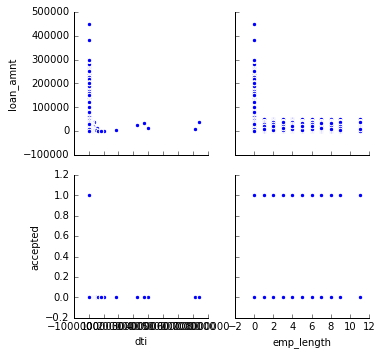

In [398]:
#sns.pairplot(data, x_vars=['dti','emp_length','zip','policy_code'], y_vars=['loan_amnt','accepted'])
sns.pairplot(data, x_vars=['dti','emp_length'], y_vars=['loan_amnt','accepted'])

# Preparing Data for Training a Model

In [60]:
#checking the date columns fit and overlap
#rejected2015_16.issue_d.unique()
#loans2015_16_shared.issue_d.unique()

# sort the data by date
data.sort_values(by='date',inplace=True,axis=0) #use sort_values(by=...) for future
data['accepted'] = pd.to_numeric(data['accepted'])
#for col in data.columns: 
#    print col
#Seperating into train and test datsets: need to take the last days as test, since we will want always to test on NEWER data than we have
data['date'] = pd.to_numeric(data.date)



In [54]:
#Preprocessing Date Column
#since scikit can't work with dates themselves, we will encode them as months from first one
#data.date.unique()
#starting_month = pd.to_datetime('2015-01-01')
#data['months_since'] = (pd.to_datetime(data.date) - starting_month)/ np.timedelta64(1, 'M')
data['months_since'].head()
data = data.drop('date',axis=1)
data['date'] = data['months_since']
data = data.drop('months_since',axis=1)

data.head(2)

,dti,title,emp_length,policy_code,loan_amnt,state,accepted,date
0,26.02,Debt consolidation,11.0,1.0,25000.0,VA,1,10.973531
1,18.00,Debt consolidation,11.0,1.0,14025.0,WI,1,10.973531


In [10]:
## checking for nulls or infinity

#data2015_16[data2015_16.isnull().any(axis=1)]
#len(data[data.isnull().any(axis=1)])
# there are 355839 nulls. 
# 355839.0/(len(data)) = 0.0419
# null data is only 4%, thus we can drop it.

data = data.dropna(axis=0)
len(data)

6919614

In [6]:
## SAVING DATA AGAIN
#data.to_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/data.csv")
#data = pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/LoanData/data.csv")
#data.drop('Unnamed: 0',axis=1,inplace=True)
#data.drop('Unnamed: 0.1',axis=1,inplace=True)
data.head(3)

,dti,emp_length,policy_code,loan_amnt,accepted,date,title_Business,title_Car,title_Credit card,title_Debt consolidation,title_Green loan,title_Home improvement,title_House,title_Major purchase,title_Medical,title_Moving,title_Other,title_Student Loan,title_Vacation,title_considerate,title_educational,title_vacation,title_wedding,state_AK,state_AL,...,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,26.02,11.0,1.0,25000.0,1,10.973531,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,18.00,11.0,1.0,14025.0,1,10.973531,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,31.04,11.0,1.0,10000.0,1,10.973531,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
## Bulding higher degrees and polynomial features for the polynoamisl regression
#from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(degree=3,int)
#X_poly = poly.fit_transform(X)

for col in ['dti','emp_length','policy_code','date']:
    data[col] = pd.to_numeric(data[col], errors ='coerce')
    for degree in [2,3]:
        col_newname = str(col)+"^"+str(degree)
        col_value = data[col].pow(degree)
        data[col_newname] = col_value
        
#Add only some meaningful interactions
for col1 in ['loan_amnt','accepted']:
    for col2 in ['dti','emp_length','policy_code']:
        newcolname = str(col1) + "*" + str(col2)
        data[newcolname] = data[col1]*data[col2]

data.head(2)    

,dti,emp_length,policy_code,loan_amnt,accepted,date,title_Business,title_Car,title_Credit card,title_Debt consolidation,title_Green loan,title_Home improvement,title_House,title_Major purchase,title_Medical,title_Moving,title_Other,title_Student Loan,title_Vacation,title_considerate,title_educational,title_vacation,title_wedding,state_AK,state_AL,...,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,dti^2,dti^3,emp_length^2,emp_length^3,policy_code^2,policy_code^3,date^2,date^3,loan_amnt*dti,loan_amnt*emp_length,loan_amnt*policy_code,accepted*dti,accepted*emp_length,accepted*policy_code
0,26.02,11.0,1.0,25000.0,1,10.973531,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,677.0404,17616.591208,121.0,1331.0,1.0,1.0,120.418389,1321.414957,650500.0,275000.0,25000.0,26.02,11.0,1.0
1,18.00,11.0,1.0,14025.0,1,10.973531,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,324.0000,5832.000000,121.0,1331.0,1.0,1.0,120.418389,1321.414957,252450.0,154275.0,14025.0,18.00,11.0,1.0


In [11]:
#X = data.loc[:, data.columns!='accepted'] #no zip (3) or state info (7:-1
X = data.drop(['accepted'], axis=1)
y = data['accepted']

#from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# we want nonrandomized split but timewise split

splitpoint = int(0.8*len(data))
## FIRSTLY, working on the code using on small subset of data
X_train, X_test = X[:splitpoint], X[splitpoint:]
y_train, y_test = y[:splitpoint], y[splitpoint:]

### RESCALE / STANDARTIZE DATA

In [12]:
# RESCALE / STANDARTIZE DATA
from sklearn import preprocessing 
sc = preprocessing.MinMaxScaler(feature_range=(0, 1))
#sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_train_std[:10]


array([[  4.77096878e-05,   1.00000000e+00,   5.00000000e-01,
          5.34521158e-02,   4.77142857e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

# Training a Classification Model

In [51]:
from sklearn.linear_model import LogisticRegression
# Create linear regression object
#from sklearn.linear_model.LinearRegression()
cls = LogisticRegression(class_weight={True:2.5,False:1}, random_state=0)
#C=1000.0, random_state=0
# Train the model using the training sets
cls.fit(X_train,y_train)


LogisticRegression(C=1.0, class_weight={False: 1, True: 2.5}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [52]:
### FOR INITIAL VERIFICATION ONLY:
# Compute RMSE on training data
# p = np.array([linreg.predict(xi) for xi in x])
p = cls.predict(X_train[0:100])
# Now we can constuct a vector of errors
# Let's see the error on the first 10 predictions
sum(p)
#err = abs(p-X_train[0:100])
#print err[:10]

8

# Checking Model Results and Performance, Cross Validation

In [53]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import KFold

kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 
KFold(n_splits=5, random_state=None, shuffle=False)

# Perform K-fold cross validation
scores = cross_val_score(cls, X_train, y_train, cv=5)
print 'Cross-validated scores:', scores
print "Mean CV Score:", np.mean(scores)

KFold(n_splits=5, random_state=None, shuffle=False)
Cross-validated scores: [ 0.41730946  0.4623119   0.41084958  0.41465908  0.40538617]


In [54]:
# Make cross validated predictions
predictions = cross_val_predict(cls, X_train, y_train, cv=5)
sum(predictions)/len(X_train)

228338

In [55]:
accuracy = metrics.accuracy_score(y_train, predictions)
print "Cross-Predicted Accuracy:", accuracy


Cross-Predicted Accuracy: 0.422103268826


In [ ]:

# Plot outputs
%matplotlib inline
pl.plot(p, y_test,'ro')
pl.plot([0,50],[0,50], 'g-')
pl.xlabel('predicted')
pl.ylabel('real')
pl.show()

## Testing Set Cross Validation Test


In [ ]:
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 
KFold(n_splits=5, random_state=None, shuffle=False)

# Perform K-fold cross validation
scores = cross_val_score(cls, X_test, y_test, cv=5)
print 'Cross-validated scores:', scores
print "Mean CV Score:", np.mean(scores)

In [ ]:
# Make cross validated predictions
predictions = cross_val_predict(cls, X_train, y_train, cv=5)
sum(predictions)/len(X_train)
accuracy = metrics.accuracy_score(y_train, predictions)
print "Cross-Predicted Accuracy:", accuracy


# WHAT IS THE MAXIMUM LOAN SIZE STILL ACCEPTED?
#### An iterative loan size acceptance predictor
To check what is the maximal size of loan, we build an algorithm which iteratively increases the loan size requested until not accepted anymore. 

In [59]:
#take a common sample from the dataset - the mode of each column
samplrow = data.mode(axis=0)

In [72]:
samplrow['emp_length'] = 8
samplrow['loan_amnt'] = 100
samplrow['title_Debt consolidation'] = 1
samplrow['dti'] = 30
samplrow.drop('accepted',axis=1,inplace=True)
samplrow

,dti,emp_length,policy_code,loan_amnt,date,title_Business,title_Car,title_Credit card,title_Debt consolidation,title_Green loan,title_Home improvement,title_House,title_Major purchase,title_Medical,title_Moving,title_Other,title_Student Loan,title_Vacation,title_considerate,title_educational,title_vacation,title_wedding,state_AK,state_AL,state_AR,...,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,dti^2,dti^3,emp_length^2,emp_length^3,policy_code^2,policy_code^3,date^2,date^3,loan_amnt*dti,loan_amnt*emp_length,loan_amnt*policy_code,accepted*dti,accepted*emp_length,accepted*policy_code
0,0.3,0.8,0.0,100,13.963326,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,194.974466,2722.491973,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
loanrow = sc.transform(samplrow)
loanrow

array([[  2.29543280e-06,   7.27272727e-02,   0.00000000e+00,
         -1.78173719e-03,   6.07142857e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

In [77]:
sc.transform(100)

ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,87)

In [79]:
#standartize
loanrow = sc.transform(samplrow)

loan = 100
inc = 100
last_accepted_loan = None
pred = 1

while pred == 1 and loan<1000000:
    samplrow['loan_amnt'] = loan
    loanrow = sc.transform(samplrow)
    pred = cls.predict(loanrow)
    last_accepted_loan = loan
    loan = loan+inc
    print loan, pred

print "last_accepted_loan: ", last_accepted_loan

200 [1]
300 [1]
400 [1]
500 [1]
600 [1]
700 [1]
800 [1]
900 [1]
1000 [1]
1100 [1]
1200 [1]
1300 [1]
1400 [1]
1500 [1]
1600 [1]
1700 [1]
1800 [1]
1900 [1]
2000 [1]
2100 [1]
2200 [1]
2300 [1]
2400 [1]
2500 [1]
2600 [1]
2700 [1]
2800 [1]
2900 [1]
3000 [1]
3100 [1]
3200 [1]
3300 [1]
3400 [1]
3500 [1]
3600 [1]
3700 [1]
3800 [1]
3900 [1]
4000 [1]
4100 [1]
4200 [1]
4300 [1]
4400 [1]
4500 [1]
4600 [1]
4700 [1]
4800 [1]
4900 [1]
5000 [1]
5100 [1]
5200 [1]
5300 [1]
5400 [1]
5500 [1]
5600 [1]
5700 [1]
5800 [1]
5900 [1]
6000 [1]
6100 [1]
6200 [1]
6300 [1]
6400 [1]
6500 [1]
6600 [1]
6700 [1]
6800 [1]
6900 [1]
7000 [1]
7100 [1]
7200 [1]
7300 [1]
7400 [1]
7500 [1]
7600 [1]
7700 [1]
7800 [1]
7900 [1]
8000 [1]
8100 [1]
8200 [1]
8300 [1]
8400 [1]
8500 [1]
8600 [1]
8700 [1]
8800 [1]
8900 [1]
9000 [1]
9100 [1]
9200 [1]
9300 [1]
9400 [1]
9500 [1]
9600 [1]
9700 [1]
9800 [1]
9900 [1]
10000 [1]
10100 [1]
10200 [1]
10300 [1]
10400 [1]
10500 [1]
10600 [1]
10700 [1]
10800 [1]
10900 [1]
11000 [1]
11100 [1]
11200 